# Egyptian License Plate Classification - Kaggle Notebook

This notebook trains a CNN for classifying Egyptian license plates into 6 categories: 
Private (Light Blue), Taxi (Orange), Commercial (Red), Public Transport (Grey), Diplomats (Green), Tourist & Temporary (Yellow).
Uses PyTorch with transfer learning from ResNet-50.
Handles class imbalance (e.g., fewer Public Transport images) using weighted loss and oversampling.
Data paths: /kaggle/input/egyptian-license-plate/data/train, val, test.
Run on Kaggle with GPU for faster training.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import pandas as pd

# Set device (use GPU on Kaggle)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Paths and Analysis
Define paths and analyze class distribution to detect imbalance.

In [2]:
train_dir = '/kaggle/input/egypt-license-plate/data/train'
val_dir = '/kaggle/input/egypt-license-plate/data/val'
test_dir = '/kaggle/input/egypt-license-plate/data/test'

# Basic transforms for loading
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=base_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)

# Class mapping
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Analyze class distribution
def get_labels(dataset):
    return [label for _, label in dataset]

train_labels = get_labels(train_dataset)
val_labels = get_labels(val_dataset)
test_labels = get_labels(test_dataset)

train_dist = Counter(train_labels)
val_dist = Counter(val_labels)
test_dist = Counter(test_labels)

print("Train distribution:", {class_names[k]: v for k, v in train_dist.items()})
print("Val distribution:", {class_names[k]: v for k, v in val_dist.items()})
print("Test distribution:", {class_names[k]: v for k, v in test_dist.items()})

Classes: ['Commercial', 'Diplomats', 'Private', 'PublicTransport', 'Taxi', 'TouristTemporary']
Train distribution: {'Commercial': 150, 'Diplomats': 163, 'Private': 150, 'PublicTransport': 42, 'Taxi': 150, 'TouristTemporary': 150}
Val distribution: {'Commercial': 38, 'Diplomats': 38, 'Private': 38, 'PublicTransport': 5, 'Taxi': 38, 'TouristTemporary': 38}
Test distribution: {'Commercial': 3, 'Diplomats': 3, 'Private': 3, 'PublicTransport': 3, 'Taxi': 3, 'TouristTemporary': 3}


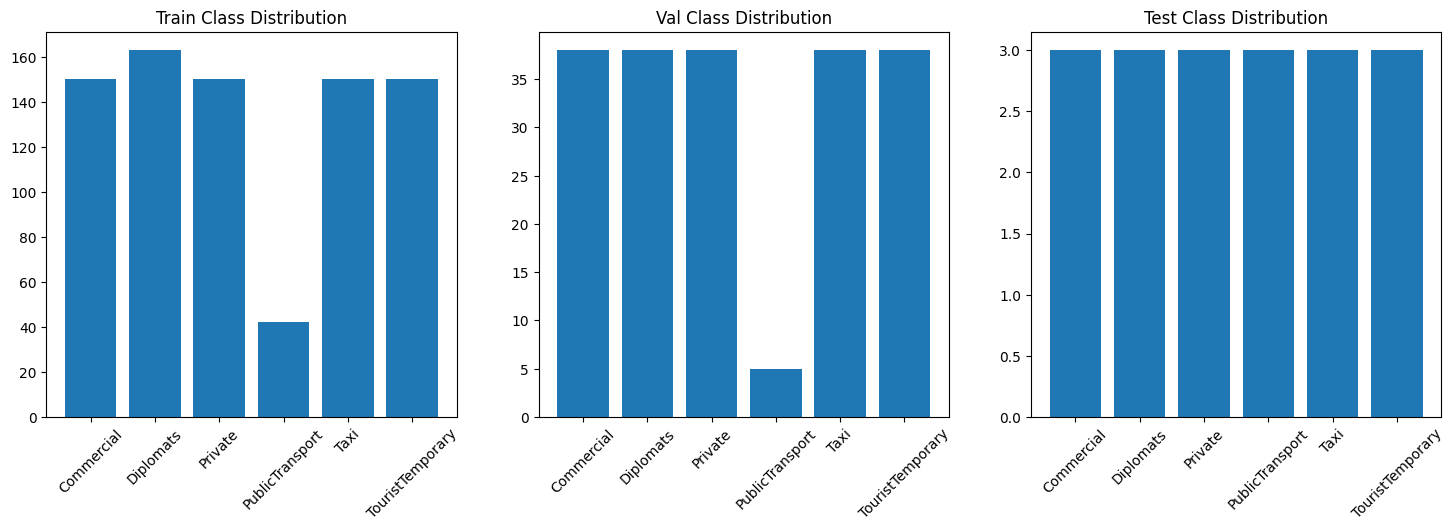

In [3]:
# Plot distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].bar(class_names, [train_dist[i] for i in range(num_classes)])
axs[0].set_title('Train Class Distribution')
axs[0].tick_params(axis='x', rotation=45)
axs[1].bar(class_names, [val_dist[i] for i in range(num_classes)])
axs[1].set_title('Val Class Distribution')
axs[1].tick_params(axis='x', rotation=45)
axs[2].bar(class_names, [test_dist[i] for i in range(num_classes)])
axs[2].set_title('Test Class Distribution')
axs[2].tick_params(axis='x', rotation=45)
plt.show()

In [4]:
# Compute class weights for imbalance (higher weight for rare classes like Public Transport)
class_counts = np.array([train_dist.get(i, 0) + val_dist.get(i, 0) for i in range(num_classes)])
class_weights = torch.tensor(np.max(class_counts) / class_counts, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")

Class weights: tensor([1.0691, 1.0000, 1.0691, 4.2766, 1.0691, 1.0691], device='cuda:0')


## 2. Data Augmentation and Loaders
Apply augmentation for train and create loaders with oversampling.

In [5]:
# Oversampling sampler for train imbalance
train_sampler_weights = [class_weights[label].item() for _, label in train_dataset]  # Use weights inversely proportional
train_sampler = WeightedRandomSampler(train_sampler_weights, len(train_sampler_weights))

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## 3. Model Architecture
Use ResNet-50 with transfer learning.

In [6]:
# Augmentation for train: Adjusted to preserve color features
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduce from 15 to 10
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Reduce range
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Reduce intensity
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Reload train with adjusted augmentation, val/test without
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=base_transform)

In [7]:
from torchvision.models import ResNet50_Weights

# Transfer learning from ResNet-50
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # Freeze base layers initially

# Replace FC layer for 6 classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.35),  # Reduce dropout to 0.35
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Custom Focal Loss with class-wise alpha
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha if alpha is not None else class_weights  # Use class_weights as alpha
    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none', weight=self.alpha)(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

criterion = FocalLoss(gamma=3.0)
optimizer = optim.AdamW(model.fc.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)  # Increase T_max to 40

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s] 


## 4. Training with Cross-Validation
Use 5-fold CV on train+val for robust training.

In [8]:
from torchvision.models import ResNet50_Weights

# Combine train + val for 5-fold CV
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_labels = train_dataset.targets + val_dataset.targets

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

epochs = 40  # Increase from 30 to 40
patience = 7  # Increase from 5 to 7
batch_size = 64  # Increase from 32 to 64

for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(full_labels)), full_labels)):
    print(f"Fold {fold+1}/5")
    
    cv_train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    cv_val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
    
    # Sampler for CV train
    cv_train_labels = [full_labels[i] for i in train_idx]
    cv_train_dist = Counter(cv_train_labels)
    cv_sampler_weights = [class_weights[full_labels[i]].item() for i in train_idx]
    cv_train_sampler = WeightedRandomSampler(cv_sampler_weights, len(cv_sampler_weights))
    
    cv_train_loader = DataLoader(cv_train_dataset, batch_size=batch_size, sampler=cv_train_sampler, num_workers=4)
    cv_val_loader = DataLoader(cv_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Re-init model per fold
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(nn.Linear(num_features, 512), nn.ReLU(), nn.Dropout(0.35), nn.Linear(512, num_classes))
    model.to(device)
    optimizer = optim.AdamW(model.fc.parameters(), lr=0.0005, weight_decay=1e-4)
    
    best_val_acc = 0.0
    early_stop_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in cv_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in cv_val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        val_acc = accuracy_score(val_true, val_preds)
        scheduler.step()
        
        print(f"Epoch {epoch+1}: Train Loss {train_loss/len(cv_train_loader):.4f}, Val Loss {val_loss/len(cv_val_loader):.4f}, Val Acc {val_acc:.4f}")
        
        if epoch == 5:  # Unfreeze layer4 earlier at epoch 5
            for param in model.layer4.parameters():
                param.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)  # Higher lr after unfreeze
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'/kaggle/working/best_model_fold{fold+1}.pt')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping")
                break
    
    cv_accuracies.append(best_val_acc)

print(f"CV Mean Accuracy: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")

Fold 1/5
Epoch 1: Train Loss 1.5446, Val Loss 0.8687, Val Acc 0.3000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 2: Train Loss 0.7945, Val Loss 0.4873, Val Acc 0.6300
Epoch 3: Train Loss 0.6188, Val Loss 0.4439, Val Acc 0.5300
Epoch 4: Train Loss 0.4851, Val Loss 0.4010, Val Acc 0.6200
Epoch 5: Train Loss 0.4326, Val Loss 0.3970, Val Acc 0.6450
Epoch 6: Train Loss 0.3640, Val Loss 0.3770, Val Acc 0.6600
Epoch 7: Train Loss 0.3698, Val Loss 0.3302, Val Acc 0.7150
Epoch 8: Train Loss 0.2969, Val Loss 0.3378, Val Acc 0.7050
Epoch 9: Train Loss 0.2202, Val Loss 0.1963, Val Acc 0.7050
Epoch 10: Train Loss 0.1870, Val Loss 0.1969, Val Acc 0.7300
Epoch 11: Train Loss 0.1521, Val Loss 0.1976, Val Acc 0.6950
Epoch 12: Train Loss 0.1333, Val Loss 0.2109, Val Acc 0.7500
Epoch 13: Train Loss 0.1404, Val Loss 0.1658, Val Acc 0.7700
Epoch 14: Train Loss 0.1232, Val Loss 0.1872, Val Acc 0.7300
Epoch 15: Train Loss 0.1130, Val Loss 0.3033, Val Acc 0.7200
Epoch 16: Train Loss 0.1257, Val Loss 0.2274, Val Acc 0.6900
Epoch 17: Train Loss 0.1385, Val Loss 0.2388, Val Acc 0.7000
Epoch 18: Train Loss 0.1019, Val

In [9]:
# Load best model (e.g., fold 1) for further use
model.load_state_dict(torch.load('/kaggle/working/best_model_fold4.pt'))

<All keys matched successfully>

## 5. Evaluation on Test Set
Evaluate accuracy, report, and confusion matrix.

In [10]:
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# Per-class metrics
print(classification_report(test_true, test_preds, target_names=class_names))

Test Accuracy: 0.9444
                  precision    recall  f1-score   support

      Commercial       1.00      1.00      1.00         3
       Diplomats       1.00      1.00      1.00         3
         Private       0.75      1.00      0.86         3
 PublicTransport       1.00      0.67      0.80         3
            Taxi       1.00      1.00      1.00         3
TouristTemporary       1.00      1.00      1.00         3

        accuracy                           0.94        18
       macro avg       0.96      0.94      0.94        18
    weighted avg       0.96      0.94      0.94        18



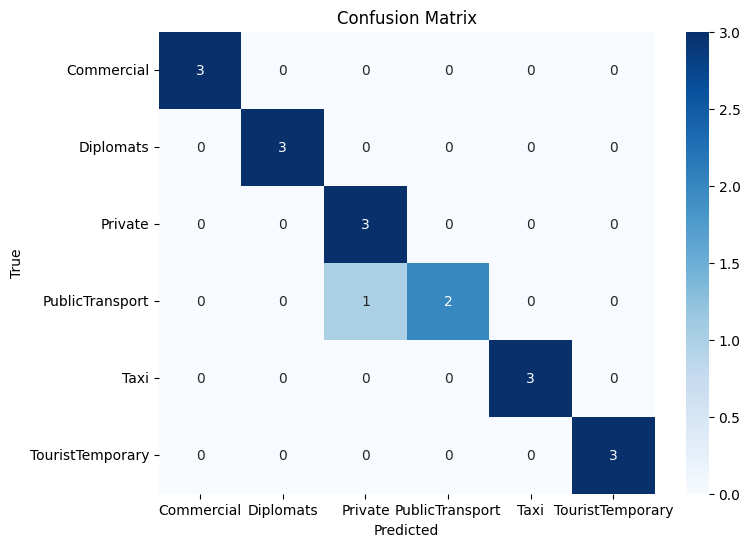

In [11]:
# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 6. Inference System
Functions for single and batch inference, output CSV as required.

In [12]:
# Function for single image inference
def infer(image_path, model, transform):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        prob = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(output).item()
        pred_class = class_names[pred_idx].lower().replace(' & ', '_').replace(' ', '_')  # Format: 'private', 'public_transport', etc.
        confidence = prob[pred_idx].item()
    return pred_class, confidence

# Batch inference on folder (e.g., test folder or custom)
def batch_infer(folder_path, model, transform, output_csv='/kaggle/working/output.csv'):
    results = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(root, filename)
                pred, conf = infer(path, model, transform)
                results.append([filename, pred, round(conf, 3)])
    df = pd.DataFrame(results, columns=['filename', 'predicted_plate_type', 'confidence'])
    df.to_csv(output_csv, index=False)
    print(f"CSV saved to {output_csv}")
    return df

In [13]:
# Example: Batch infer on test_dir
batch_infer(test_dir, model, base_transform)

CSV saved to /kaggle/working/output.csv


,filename,predicted_plate_type,confidence
0,plate12.jpg,private,1.000
1,plate11.jpg,publictransport,0.991
2,plate10.png,publictransport,0.975
3,plate5.jpg,diplomats,0.786
4,plate6.jpg,diplomats,0.799
5,plate4.jpg,diplomats,0.816
6,plate17.jpg,touristtemporary,0.893
7,plate16.jpg,touristtemporary,0.817
8,plate18.jpg,touristtemporary,0.787
9,plate15.jpg,taxi,0.843


## 7. Visualize Test Images with Predictions
Display sample images from the test folder with their predicted type and confidence.

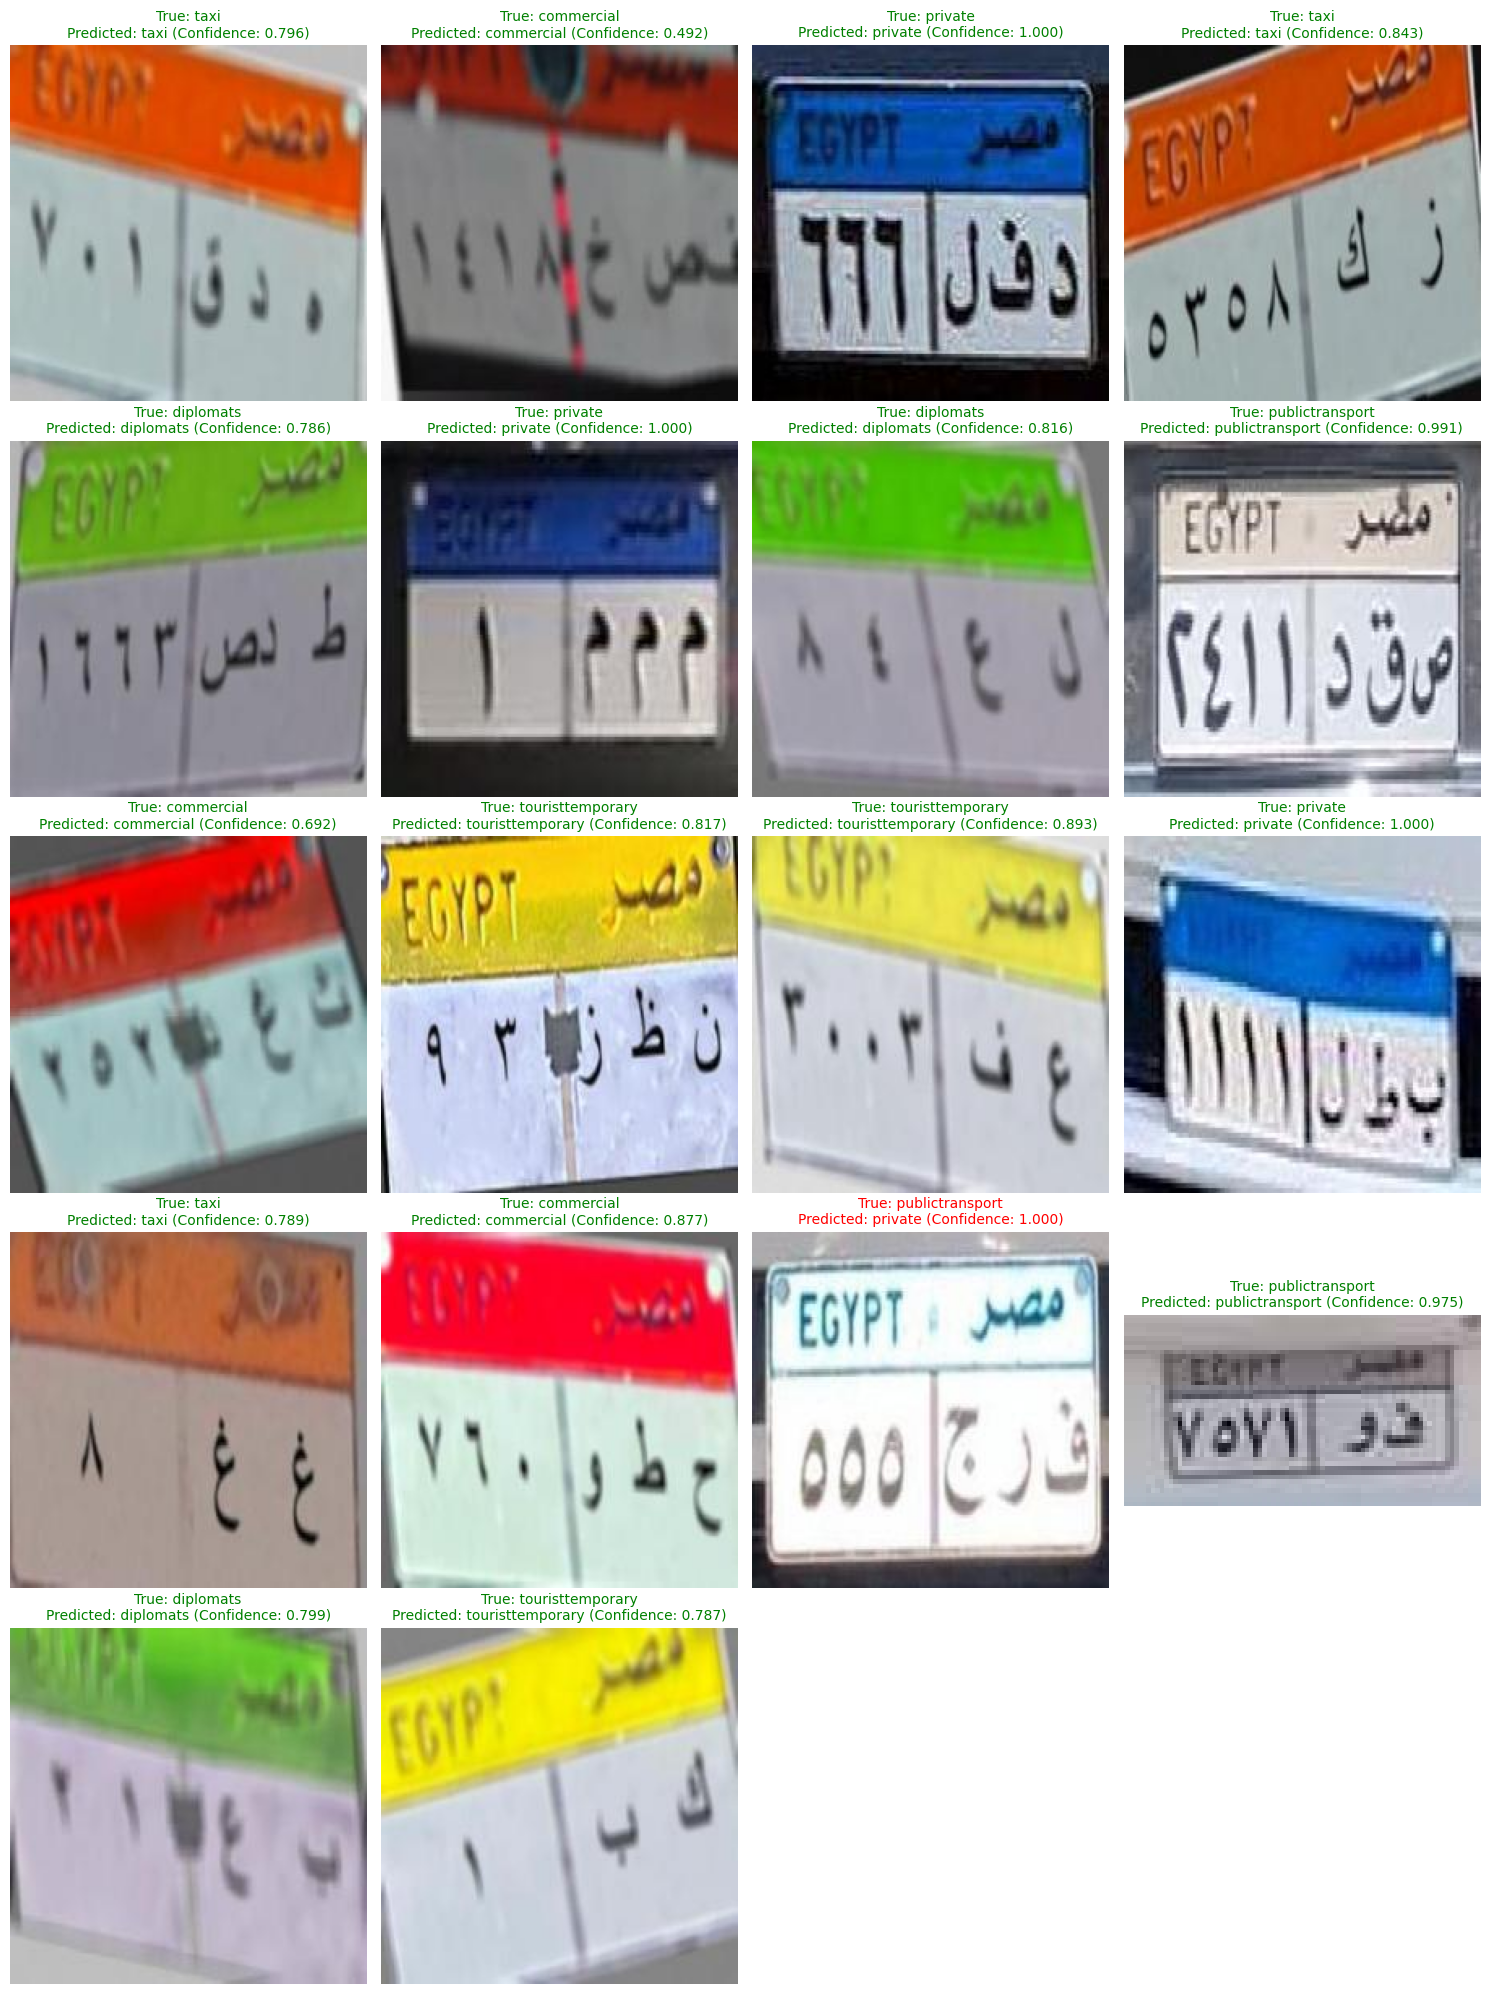

In [14]:
import random 
import os

# Get all image paths from test_dir (including subfolders)
test_image_paths = []
for root, _, files in os.walk(test_dir):
    for filename in files:
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            test_image_paths.append(os.path.join(root, filename))

# Optional: Shuffle or limit to N images for display (e.g., 20 to avoid too many plots)
num_display = 20  # Change as needed
random.shuffle(test_image_paths)  # Random for variety
test_image_paths = test_image_paths[:num_display]

# Plot in grid (e.g., 4 columns)
cols = 4
rows = (len(test_image_paths) + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 4))
axs = axs.flatten()  # Flatten for easy indexing

for i, path in enumerate(test_image_paths):
    # Get prediction and confidence
    pred, conf = infer(path, model, base_transform)
    
    # Get true label from folder name (e.g., 'Private' -> 'private')
    true_folder = os.path.basename(os.path.dirname(path))  # Get folder name
    true_label = true_folder.lower().replace(' & ', '_').replace(' ', '_')  # Format like pred
    
    # Determine if correct (for color highlight)
    is_correct = (true_label == pred)
    title_color = 'green' if is_correct else 'red'
    
    # Load and display image
    img = Image.open(path).convert('RGB')
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"True: {true_label}\nPredicted: {pred} (Confidence: {conf:.3f})", 
                     fontsize=10, color=title_color)

# Hide unused axes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()